This notebook demonstrates how use the model api to run predictions and get information from the model. You can use it as basis to write your own experiements using the model in this container.
To start, import _modelapi.model_, which will give us access to the api of the model in this container.

In [2]:
from modelapi import model
import h5py

### Running inference 
##### General info
The model was trained on the MSCOCO dataset (http://cocodataset.org/#home)
-> It therefore also assigns one of the 80 labels of the dataset to each detected object

Currently the model only returns the raw result vector normalized on the image dims -> one has to first backproject this output to the original pixel locations on the original image before it can be used

In [3]:
# COCO dataset labels as used here 
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

Ask the model for a list of sample data, then run a prediction on the first of the sample dataset, and then display the prediction result output.

If the model does not provide any sample data, print an error message (this part also shows how to read meta info - like the model's name - from the models config).

In [4]:
samples = model.get_samples()
if len(samples["files"]) > 0:
    inputFile = samples["folder"] + "/" + samples["files"][0]
    result = model.predict(inputFile)
    print(result)
    for i, output in enumerate(result["output"]):
        print("\n" + result["model"]["name"] + " Output " + str(i) + ":")
        print("  Type:  " + output["type"])
        print("  Name:  " + output["name"])
        print("  Shape: " + str(output["shape"]))
        print("  Prediction:")
        if output["type"] in ["mask_image", "image"]:
            # if output seems to be an image, try displaying it nicely with PIL
            try:
                import PIL
                image = PIL.Image.fromarray(output["prediction"])
                display(image)
            except:
                display(output["prediction"])
        else:
            display(output["prediction"])
else:
    model_name = model.get_config()["meta"]["name"]
    print(model_name + " does not provide any sample data, please try your own data.")

{'processing_time': 1.809, 'output': [{'shape': [1, 13, 13, 255], 'description': u'A (13,13,255) numpy array where 255 = 3[Bounding Boxes per Cell]*(4[x,y,w,h of BB]+1[BB confidence score]+80[class probabilities] for each of the 13x13 grid cells. More desc in the sandbox.ipynb and here: https://towardsdatascience.com/review-yolov3-you-only-look-once-object-detection-eab75d7a1ba6', 'type': u'custom', 'prediction': 'api/output/2019-08-21-16-27-15-633588.h5', 'name': u'BB Locations and Class Probabilities'}], 'model': {'id': u'd9564b79-1f1a-4ac4-891d-2767a0d6bc95', 'name': u'YOLOv3'}, 'timestamp': '2019-08-21-16-27-15-637084'}

YOLOv3 Output 0:
  Type:  custom
  Name:  BB Locations and Class Probabilities
  Shape: [1, 13, 13, 255]
  Prediction:


'api/output/2019-08-21-16-27-15-633588.h5'

In [25]:
# get path to resulting file 
resultFile = output["prediction"].replace("api", "")

In [26]:
# load file with h5py
f = h5py.File(resultFile, 'r')

In [21]:
# find out what our result looks like
print(f.keys())

[u'BB Locations and Class Probabilities']

In [30]:
# load the actiaö prediction and check for correct shape
prediction = f[f.keys()[0]]
print('Shape of prediction is: {}'.format(prediction.shape))

Shape of prediction is: (1, 13, 13, 255)


In [31]:
# postprocessing the output so we can actually see a result
from matplotlib import pyplot
from matplotlib.patches import Rectangle
import numpy as np
 
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score
 
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes
 
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
 
def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0
                    
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores
 
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

('zebra', 94.91060972213745)
('zebra', 99.86329674720764)
('zebra', 96.8708872795105)


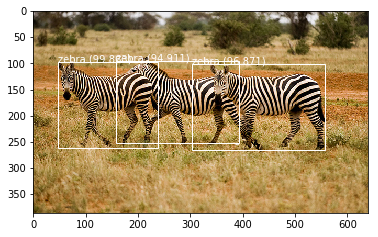

In [33]:
image_w = 640
image_h = 386
input_h = input_w = 416
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len([prediction])):
	# decode the output of the network
	boxes += decode_netout([prediction][i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes('sample_data/zebra.jpg', v_boxes, v_labels, v_scores)